# Example 5. Multiparticle tracking in 3D

This method is no longer optimal. We recommend the [LodeSTAR method](../LodeSTAR/07.track_3D_holograph.ipynb) instead.

Trains a U-Net to locate spherical particles in 3d.

## 1. Setup

Imports and defines the objects needed for this example.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import skimage
import skimage.measure

import deeptrack as dt

IMAGE_SIZE = 512
MIN_Z = 2e-6
MAX_Z = 30e-6
Z_SCALE = 3.45e-7
PIXEL_SCALE = 3.45e-7
K_VEC = (0.2, 0.3, 1) # Ask Erik for correct values
REF_AMPLITUDE = 0.1 # Relative to object wave

## 2. Defining the dataset

Defining the optical device, with Coma aberration.

In [18]:
pupil = dt.HorizontalComa(coefficient=lambda: 0.2 +  0.3*np.random.rand()) >> dt.VerticalComa(coefficient=lambda:-0.2 - np.random.rand()*0.2)

optics = dt.Brightfield(
    NA=1.3,
    wavelength=633e-9,
    magnification=1,
    resolution=lambda magnification: PIXEL_SCALE * magnification,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    upscale=1,
    pupil=pupil
)

Defining the particles.

In [19]:
particles = dt.MieSphere(
    position=lambda: 20 + np.random.rand(2) * (IMAGE_SIZE - 40),
    z=lambda: + MIN_Z / PIXEL_SCALE + (np.random.rand() * (MAX_Z / PIXEL_SCALE - MIN_Z / PIXEL_SCALE)),
    position_unit="pixel",
    refractive_index=lambda: 1.45 + np.random.rand() * 0.1,
    radius=lambda: 190e-9 + np.random.rand() * 100e-9,
    L=10,
    return_field=True
)
particles = particles ^ (lambda: np.random.randint(2, 8))

Adding noise, illumination gradient and normalization

In [20]:
class AddPlaneWave(dt.Feature):
    def __init__(self, amplitude=1, k_vec=(0, 0, 1), phase=0):
        super().__init__(amplitude=amplitude, k_vec=k_vec, phase=phase)
    
    def get(self, field, amplitude, k_vec, phase, **kwargs):

        fourier_field = np.fft.fft2(field, axes=(0, 1))
        fourier_field = np.fft.fftshift(fourier_field, axes=(0, 1))
        
        k_vec = np.array(k_vec) / np.linalg.norm(k_vec)
        k_x = k_vec[0] * field.shape[0] / 2 + field.shape[0] / 2
        k_y = k_vec[1] * field.shape[1] / 2 + field.shape[1] / 2

        fourier_field[int(k_x), int(k_y)] += amplitude * np.exp(1j * phase) * field.size

        fourier_field = np.fft.fftshift(fourier_field, axes=(0, 1))

        return np.fft.ifft2(fourier_field, axes=(0, 1))


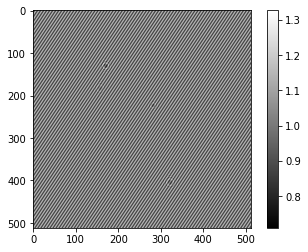

In [30]:
dataset = optics(particles) >> AddPlaneWave(amplitude=REF_AMPLITUDE, k_vec=K_VEC) >> dt.Abs() >> dt.Square()

dataset.update().plot(cmap="gray")
plt.colorbar()

In [87]:
y1 = 7467 % ((np.arange(800) + 9045) % 1654)
y2 = 1120 % ((np.arange(800) + 345) % 64)

np.correlate(y1, y2)


<ipython-input-87-4ac699785d3d>:2: RuntimeWarning: divide by zero encountered in remainder
  y2 = 1120 % ((np.arange(800) + 345) % 64)


array([6979372], dtype=int32)